## Quickstart for New Pytorch Users 

- This will be a good template for pytorch newbie.
- Plot history of training

### Basic Packages

In [1]:
# Basic Packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial import cKDTree
import gc

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### Download Datasets 

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [5]:
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [6]:
# Prep Data
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [NumData, Channels, Hight, Width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [NumData, Channels, Hight, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Explore Datasets 

- As a pytorch newbie, let's find out the class structures of `DataLoader` and see how this works
- Extract some images from the data tensor and visualize them 

In [7]:
#dir(test_dataloader)

In [8]:
# Get a batch for images and their labels
test_images, test_labels = next(iter(test_dataloader))

In [9]:
len(test_labels), test_labels.shape

(64, torch.Size([64]))

In [10]:
test_labels

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])

In [11]:
len(test_images), test_images.shape

(64, torch.Size([64, 1, 28, 28]))

In [12]:
test_images[0,0,:].shape

torch.Size([28, 28])

In [13]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if the data was normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [14]:
def plot_images(images, labels, classes, num_images=6, num_rows=2, cmap='Greys'):
    num_cols = num_images // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    for i in range(num_images):
        ax = axes[i]
        img = images[i].numpy()
        
        # If single-channel image, remove channel dimension
        if img.shape[0] == 1:
            img = img.squeeze(0)
        
        ax.imshow(img, cmap=cmap)
        ax.set_title(classes[labels[i].item()])
        ax.axis('off')
    
    # Remove any unused axes in the grid
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [15]:
classes = test_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


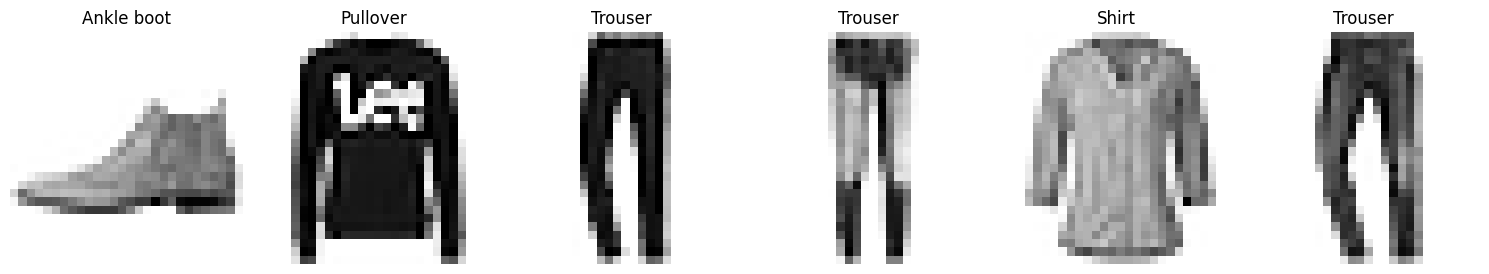

In [16]:
plot_images(test_images, test_labels, classes, num_images=6, num_rows=1)

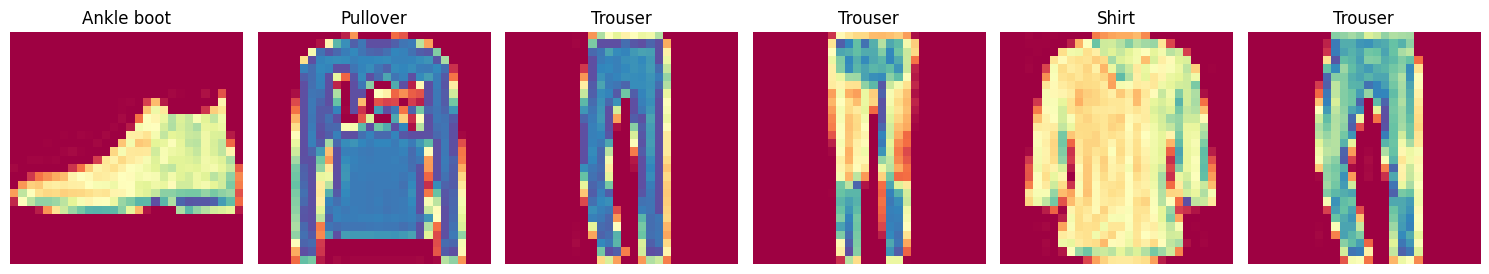

In [17]:
plot_images(test_images, test_labels, classes, num_images=6, num_rows=1,cmap='Spectral')

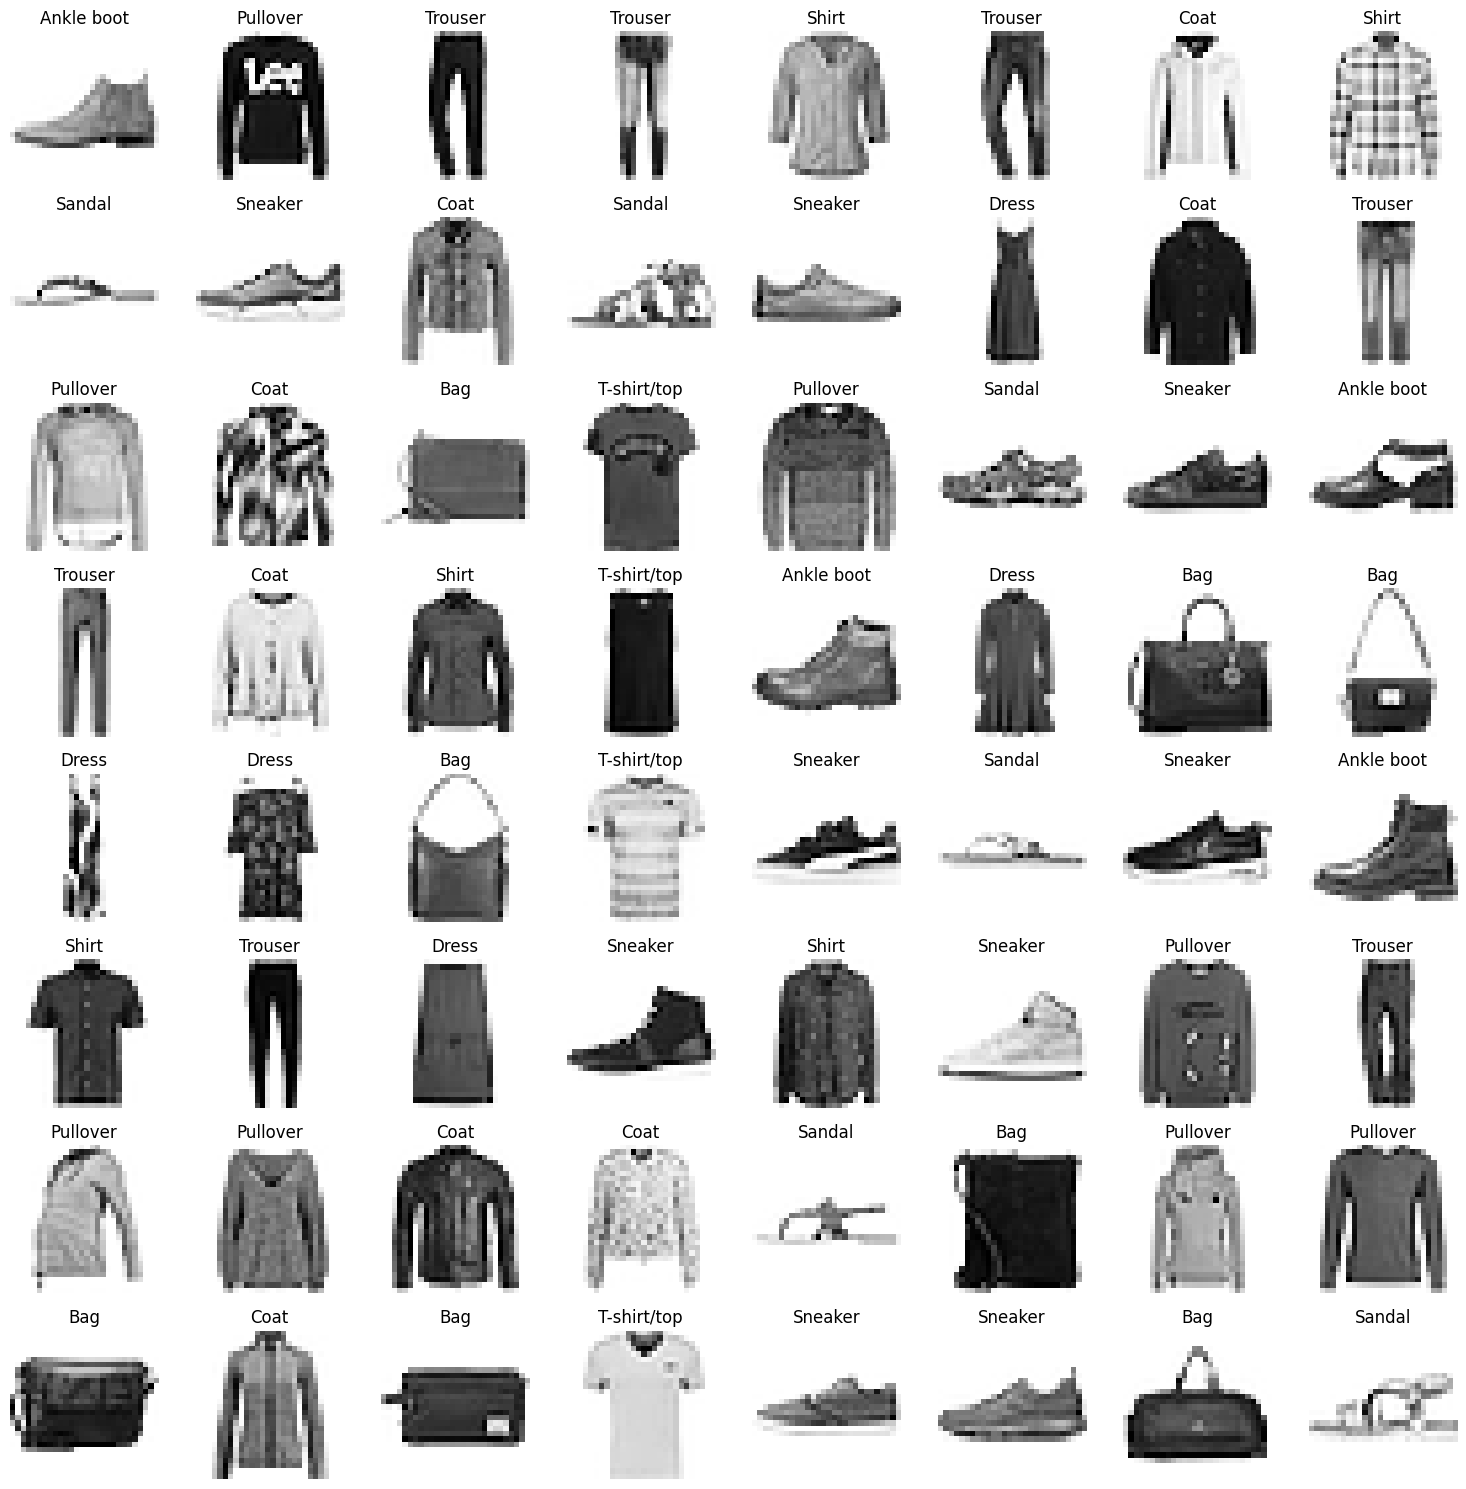

In [18]:
plot_images(test_images, test_labels, classes, num_images=64, num_rows=8)

### Creating Models

In [19]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [20]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-24449304-a305-dbe0-a5c8-bc765274bece)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-1761614d-0d31-5a98-6d73-e9cabf8b877a)


In [21]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing Model Parameters

In [22]:
# Loss Function and Optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            #print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / size

    print(f"Train Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

In [25]:
%%time
numepochs = 10
epochs = []
trlosses = []
tracces = []
tslosses = []
tsacces = []

for t in range(numepochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trloss, tracc = train(train_dataloader, model, loss_fn, optimizer)
    tsloss, tsacc = test(test_dataloader, model, loss_fn)
    epochs.append(t+1)
    trlosses.append(trloss)
    tslosses.append(tsloss)
    tracces.append(tracc)
    tsacces.append(tsacc)
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 30.6%, Avg loss: 2.225163 

Test Error: 
 Accuracy: 39.6%, Avg loss: 2.138614 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 48.0%, Avg loss: 2.005939 

Test Error: 
 Accuracy: 53.0%, Avg loss: 1.846684 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 58.1%, Avg loss: 1.659151 

Test Error: 
 Accuracy: 60.3%, Avg loss: 1.487215 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 63.1%, Avg loss: 1.347666 

Test Error: 
 Accuracy: 63.1%, Avg loss: 1.237702 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 64.9%, Avg loss: 1.148442 

Test Error: 
 Accuracy: 64.6%, Avg loss: 1.083975 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 66.4%, Avg loss: 1.022304 

Test Error: 
 Accuracy: 65.9%, Avg loss: 0.983545 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 67.7%, Avg loss: 0.936771 

Test Error: 
 Accuracy: 67.2%, Avg lo

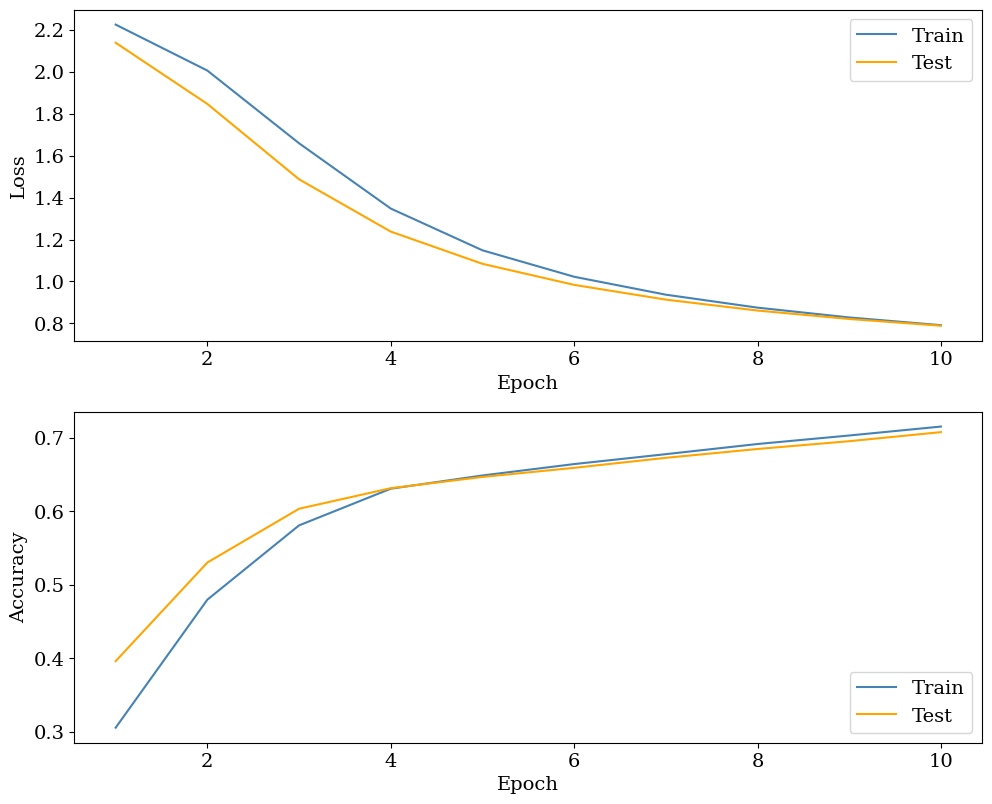

In [26]:
# plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
#plt.axis([0.9,5.9,0.0,1.1])
plt.xlabel(r'Epoch')
plt.ylabel(r'Loss')
plt.plot(epochs,trlosses,color='steelblue',label='Train')
plt.plot(epochs,tslosses,color='orange',label='Test')

# Add legend
plt.legend()

plt.subplot(2,1,2)
#plt.axis([0.9,5.9,0.5,0.7])
plt.xlabel(r'Epoch')
plt.ylabel(r'Accuracy')
#plt.yscale('log')
plt.plot(epochs,tracces,color='steelblue',label='Train')
plt.plot(epochs,tsacces,color='orange',label='Test')

# Add legend
plt.legend(loc=4)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("history_tutorial.pdf")

plt.show()

### Saving Models

In [27]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading Models

In [28]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Predictions by the Loaded Model

In [29]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [30]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
